In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:

from google.colab import files
uploaded = files.upload()
     


Saving names.txt to names.txt


In [ ]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

In [ ]:
chars = sorted(list(set(''.join(words))))
stoi = {s : i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i : s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator = g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator = g) * ((5 / 3) / (n_embed * block_size) ** 0.5) 
b1 = torch.randn(n_hidden, generator = g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.01
b2 = torch.randn(vocab_size, generator = g) * 0.01

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

11897


In [ ]:
hpreact.mean(0, keepdims = True).shape

torch.Size([1, 200])

In [ ]:
hpreact.std(0, keepdims = True).shape

torch.Size([1, 200])

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator = g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  bnmeani = hpreact.mean(0, keepdims = True)
  bnstdi = hpreact.std(0, keepdims = True)

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi


  hpreact = bngain * (hpreact - bnmeani)/bnstdi  + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  for p in parameters:
    p.grad = None

  loss.backward()

  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0:
    print(f'{i : 7d} / {max_steps : 7d} : {loss.item() : 4f}')

  lossi.append(loss.log10().item())

      0 /  200000 :  3.314171
  10000 /  200000 :  2.194067
  20000 /  200000 :  2.344365
  30000 /  200000 :  2.415973
  40000 /  200000 :  1.991240
  50000 /  200000 :  2.297981
  60000 /  200000 :  2.525739
  70000 /  200000 :  2.070531
  80000 /  200000 :  2.311183
  90000 /  200000 :  2.066165
 100000 /  200000 :  1.992951
 110000 /  200000 :  2.318187
 120000 /  200000 :  1.912349
 130000 /  200000 :  2.450223
 140000 /  200000 :  2.432061
 150000 /  200000 :  2.200301
 160000 /  200000 :  2.045954
 170000 /  200000 :  1.883493
 180000 /  200000 :  1.998794
 190000 /  200000 :  1.887291


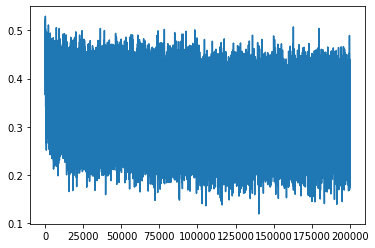

In [ ]:
plt.plot(lossi)

In [ ]:
with torch.no_grad():
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  bnmean = hpreact.mean(0, keepdims = True)
  bnstd = hpreact.std(0, keepdims = True) 

In [ ]:
@torch.no_grad()
def split_loss(split):

  x, y = {
      'train' : (Xtr, Ytr),
      'val' : (Xdev, Ydev),
      'test' : (Xte, Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean_running) / (bnstd_running) + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.0780739784240723
val 2.1128106117248535


In [ ]:
#sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim = 1)
    ix = torch.multinomial(probs, num_samples = 1, generator = g).item()
    context = context[1:] + [ix]
    out.append(ix)

    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

carmahzaylyn.
kiffinleige.
tyrencessa.
jazon.
nadelynn.
jareei.
nellara.
chaiivan.
legyn.
ham.
joce.
quint.
salin.
alianni.
waveron.
jaryxin.
kaellissa.
med.
edi.
abette.


### Pytorchifying

In [ ]:

class Linear:

  def __init__(self, fan_in, fan_out, bias = True):

    # Initialization
    self.weight = torch.randn((fan_in, fan_out), generator = g) / fan_in ** 0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):

    #Forward pass
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias

    return self.out

  def parameters(self):

    #Return the parameters
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps = 1e-5, momentum = 0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True

    #parameters trained with backprop
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):

    #calculate forwards pass
    if self.training:
      xmean = x.mean(0, keepdims = True) # batch mean
      xvar = x.std(0, keepdims = True)  # batch std
    else:
      xmean = self.running_mean
      xvar = self.running_var

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta

    #Update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.running_mean * self.momentum
        self.running_var = (1 - self.momentum) * self.running_var + self.running_var * self.momentum

    return self.out


  def parameters(self):
    return [self.gamma, self.beta]



class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return [] 






In [ ]:
n_embd = 10 # the dimensionality of the character embedding vector
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) 

C = torch.randn((vocab_size, n_embd), generator = g)
layers = [
    Linear(n_embd * block_size, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
  # last layer : make less confident
  layers[-1].weight *= 0.1
  # all other layers apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5 / 3



parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

46497


In [ ]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  #minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator = g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  #forward pass
  emb = C[Xb] #embed the characters into vectors
  x = emb.view(emb.shape[0], -1) #concatenate the vectors
  for layer in layers:
    x = layer(x)

  loss =F.cross_entropy(x, Yb) #loss function

  #backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG : would take out retain_graph

  for p in parameters:
    p.grad = None
  loss.backward()

  #update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i : 7d} / {max_steps : 7d} : {loss.item() : .4f}')

  lossi.append(loss.log10().item()) 
  break




      0 /  200000 :  3.2962


layer 1 (      Tanh): mean -0.02, std 0.75, saturated: 20.25%
layer 3 (      Tanh): mean -0.00, std 0.69, saturated: 8.38%
layer 5 (      Tanh): mean +0.00, std 0.67, saturated: 6.62%
layer 7 (      Tanh): mean -0.01, std 0.66, saturated: 5.47%
layer 9 (      Tanh): mean -0.02, std 0.66, saturated: 6.12%


Text(0.5, 1.0, 'activation distribution')

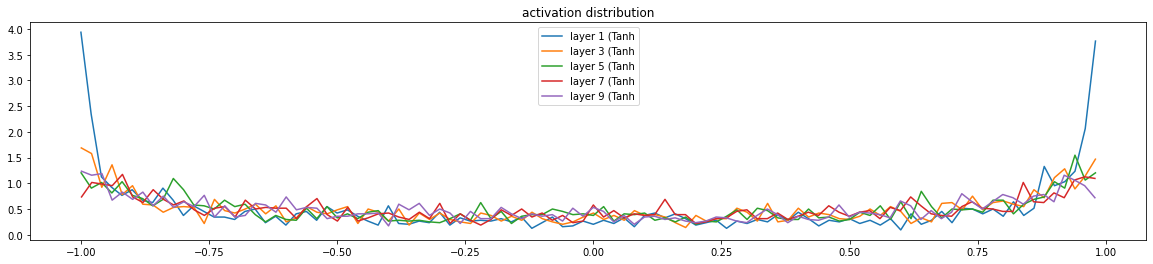

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')


layer 1 (      Tanh): mean +0.000010, std 4.205588e-04
layer 3 (      Tanh): mean -0.000003, std 3.991179e-04
layer 5 (      Tanh): mean +0.000003, std 3.743020e-04
layer 7 (      Tanh): mean +0.000015, std 3.290473e-04
layer 9 (      Tanh): mean -0.000014, std 3.054035e-04


Text(0.5, 1.0, 'gradient distribution')

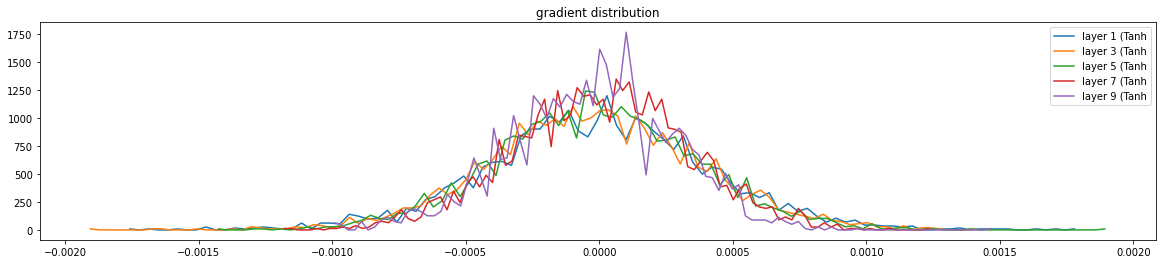

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')